<h1>Прогнозирование объемов потребления электроэнергии<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Формирование-базы-данных" data-toc-modified-id="Формирование-базы-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Формирование базы данных</a></span></li><li><span><a href="#Подготовка-обучающего-и-тестового-фрейма" data-toc-modified-id="Подготовка-обучающего-и-тестового-фрейма-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка обучающего и тестового фрейма</a></span></li><li><span><a href="#Анализ-структуры-исходных-данных" data-toc-modified-id="Анализ-структуры-исходных-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ структуры исходных данных</a></span></li><li><span><a href="#Корреляция-числовых-и-категориальных-признаков" data-toc-modified-id="Корреляция-числовых-и-категориальных-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляция числовых и категориальных признаков</a></span></li><li><span><a href="#Регрессия-Бустингом" data-toc-modified-id="Регрессия-Бустингом-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Регрессия Бустингом</a></span><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#Оценка-ценности-признаков" data-toc-modified-id="Оценка-ценности-признаков-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Оценка ценности признаков</a></span></li><li><span><a href="#Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности" data-toc-modified-id="Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности</a></span></li><li><span><a href="#Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности-(с-фильтрацией-исходных-признаков-и-временного-диапазона)" data-toc-modified-id="Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности-(с-фильтрацией-исходных-признаков-и-временного-диапазона)-6.1.3"><span class="toc-item-num">6.1.3&nbsp;&nbsp;</span>Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности (с фильтрацией исходных признаков и временного диапазона)</a></span></li><li><span><a href="#Валидация-на-свежих-данных-(январь-2024)" data-toc-modified-id="Валидация-на-свежих-данных-(январь-2024)-6.1.4"><span class="toc-item-num">6.1.4&nbsp;&nbsp;</span>Валидация на свежих данных (январь 2024)</a></span></li></ul></li></ul></li></ul></div>

**Исследуемый субъект:** республика Татарстан. Генеральная совокупность: 01.04.2013 – 31.12.2023, тестовая выборка: 2023 год (09.01.2023 – 29.12.2023), валидационная выборка: 01.2024

# Используемые ресурсы

In [1]:
import os
import re
import shutil
import requests
import datetime
import warnings
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Формирование базы данных

In [2]:
headers = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'
}

t = {'ё': 'yo', 'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e', 'ж': 'zh',
     'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k', 'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p',
     'р': 'r', 'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'h', 'ц': 'c', 'ч': 'ch', 'ш': 'sh',
     'щ': 'shch', 'ъ': '', 'ы': 'y', 'ь': '', 'э': 'e', 'ю': 'yu', 'я': 'ya'}


def translate(text: str, sep='_'):
    tx = ''
    for i in text:
        if i != ' ':
            tx += t.get(i, i)
        else:
            tx += sep
    return tx


valid_data = {}
with open('index.html', 'r', encoding='utf-8') as file:
    src = file.read()

soup = BeautifulSoup(src, 'html.parser')
anch = soup.find_all('a')

for item in anch:
    valid_data[item.text] = item.get('href')[item.get(
        'href').find('_', 36)+1:item.get('href').rfind('_')-5]


def get_data():
    #key = input('\n'.join(valid_data.keys()) + '\n')
    key = 'Республика Татарстан'
    tr_key = translate(key.lower())
    if not os.path.exists(f'./{tr_key.capitalize()}'):
        os.mkdir(f'./{tr_key.capitalize()}')
    for i in range(2013, datetime.now().year + 1):
        for j in range(1, 13):
            req = requests.get(
                url=f'https://www.atsenergo.ru/dload/fact_region/{i}{j:02}01/{i}{j:02}01_{valid_data[key]}_fact_region.xls',
                headers=headers,
                verify=False
            )
            if req.status_code == 404:
                continue
            try:
                if not os.path.exists(f'./{tr_key.capitalize()}/{tr_key}_{i}_{j:02}__{valid_data[key]}.xls'):
                    with open(f'./{tr_key.capitalize()}/{tr_key}_{i}_{j:02}__{valid_data[key]}.xls', 'wb') as file:
                        file.write(req.content)
            except Exception as ex:
                print(ex)
    return transformation_data(tr_key)


def transformation_data(key):
    for adress, dirs, files in os.walk(f'./{key.capitalize()}'):
        for name in files:
            url = os.path.join(adress, name)
            df = pd.read_excel(url, index_col=False)
            if pd.isna(df.iloc[-1, 1]):
                df = df.iloc[6:-3]
            else:
                df = df.iloc[6:]
            df.columns = ['Date', 'Hour', 'Volume']
            df = df.reset_index(drop=True)
            df['Date'] = df['Date'].apply(lambda x: x.replace('.', '-'))
            df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
            for i, j in enumerate(['Year', 'Month', 'Day']):
                if j == 'Year':
                    df.insert(i, j, df['Date'].dt.year)
                elif j == 'Month':
                    df.insert(i, j, df['Date'].dt.month)
                else:
                    df.insert(i, j, df['Date'].dt.day)
            df = df.drop(columns='Date')
            df.to_excel(url+'x', index=False)
            os.remove(url)
    return result_dataframe(key)


def result_dataframe(key):
    files_url = []
    result = pd.DataFrame()
    for adress, dirs, files in os.walk(f'./{key.capitalize()}'):
        for name in files:
            files_url.append(os.path.join(adress, name))
    for file in files_url:
        df = pd.read_excel(file, index_col=False)
        result = result._append(df)
    shutil.rmtree(f'./{key.capitalize()}')
    return result

In [3]:
warnings.filterwarnings('ignore') # супрессим предупреждения https

df = get_data()

warnings.filterwarnings("default") # возвращаем предупреждения к дефолтным настройкам

In [4]:
df

,Year,Month,Day,Hour,Volume
0,2013,4,1,1,2814.717
1,2013,4,1,2,2747.458
2,2013,4,1,3,2734.133
3,2013,4,1,4,2736.587
4,2013,4,1,5,2796.396
...,...,...,...,...,...
402,2024,1,31,19,3933.118
403,2024,1,31,20,3914.372
404,2024,1,31,21,3885.837
405,2024,1,31,22,3800.409


In [5]:
# Модуль погоды для Татарстана
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь',
                   'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
links = []
data_of_weather = []

for month in months:
    req = requests.get(url=f'https://kazan.nuipogoda.ru/{month}-2011')
    soup = BeautifulSoup(req.content, 'lxml')
    all_tds = soup.find_all('td')
    for i in range(len(all_tds)):
        try:
            links.append('https://kazan.nuipogoda.ru/' + all_tds[i].find('a').get('href'))
        except AttributeError:
            continue

for j in links:
    req=requests.get(url=j)
    soup=BeautifulSoup(req.content)
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))
    for k in range(len(trs)):
        data_of_weather.append((list(trs[k].attrs.values())[0], trs[k].find('span', class_='ht').text[:-1]))
        
df_weather = pd.DataFrame(data_of_weather, columns=['Time', 'Temperature']).astype('int64')
df_weather['Time'] = pd.to_datetime(df_weather['Time'], unit='ms')
df_weather['Year'] = df_weather['Time'].dt.year
df_weather['Month'] = df_weather['Time'].dt.month
df_weather['Day'] = df_weather['Time'].dt.day
df_weather['Hour'] = df_weather['Time'].dt.hour
df_weather = df_weather.loc[(df_weather['Hour'] != 0)].reset_index(drop=True)
df_weather.drop(columns='Time', inplace=True)
df_weather = df_weather[['Year', 'Month', 'Day', 'Hour', 'Temperature']]

In [6]:
df_weather

,Year,Month,Day,Hour,Temperature
0,2024,1,1,3,-11
1,2024,1,1,6,-10
2,2024,1,1,9,-13
3,2024,1,1,12,-15
4,2024,1,1,15,-18
...,...,...,...,...,...
37954,2010,12,31,9,-6
37955,2010,12,31,12,-6
37956,2010,12,31,15,-5
37957,2010,12,31,18,-2


In [7]:
#df.to_excel('Tatarstan.xlsx')
#df_weather.to_excel('Weather_Tatarstan.xlsx')

# работа с готовой базой без использования интернета 
#df = pd.read_excel('Tatarstan.xlsx')
#df = df [['Year', 'Month', 'Day', 'Hour', 'Volume']]
#df_weather = pd.read_excel('Weather_Tatarstan.xlsx')
#df_weather = df_weather[['Year', 'Month', 'Day', 'Hour', 'Temperature']]

# Подготовка обучающего и тестового фрейма

In [8]:
# формируем генеральную совокупность
df_general = df.copy()

df_general['date'] = pd.to_datetime(df_general[['Year', 'Month', 'Day']])
df_general['Weekday'] = df_general['date'].dt.weekday  # добавление дня недели
df_general = df_general.drop('date', axis=1)
df_general = df_general[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Volume']]  # упорядочиваем столбцы
df_general = df_general.merge(df_weather, how='left', on=['Year', 'Month', 'Day', 'Hour'])  # добавление погодного признака
df_general = df_general.drop_duplicates(subset=['Year', 'Month', 'Day', 'Hour', 'Temperature'])  # удаление возможных дубликатов
df_general.reset_index(drop=True, inplace=True)

# интерполяция пропусков (линейная, полиноминальная 2 порядка)
df_general['Temperature'] = df_general['Temperature'].interpolate(method='polynomial', order=2).round(1) 
df_general = df_general.dropna()
#df_general = df_general.fillna(0) # доработать экстраполяцию (усредненное значение за сутки)

# формируем обучающий датафрейм
df_train = df_general[df_general['Year'] < datetime.now().year - 1]

# формируем тестовую выборку
df_test = df_general[df_general['Year'] == datetime.now().year - 1]
df_test.reset_index(drop=True, inplace=True)

# формируем валидационную выборку
df_validate = df_general[df_general['Year'] == datetime.now().year]
df_validate.reset_index(drop=True, inplace=True)

# исключаем валидационную выборку из генеральной совокупности
df_general = df_general[df_general['Year'] < datetime.now().year]

In [9]:
#df_general.to_excel('Tatarstan.xlsx')
df_general

,Year,Month,Day,Hour,Weekday,Volume,Temperature
1,2013,4,1,2,0,2747.458,0.0
2,2013,4,1,3,0,2734.133,-0.1
3,2013,4,1,4,0,2736.587,-0.1
4,2013,4,1,5,0,2796.396,0.0
5,2013,4,1,6,0,2847.120,0.2
...,...,...,...,...,...,...,...
63448,2023,12,29,19,4,3735.211,-8.2
63449,2023,12,29,20,4,3675.452,-8.2
63450,2023,12,29,21,4,3653.876,-9.0
63451,2023,12,29,22,4,3598.927,-10.8


In [10]:
df_general.info() # пропуски в данных отсутствуют

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63452 entries, 1 to 63452
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         63452 non-null  int64  
 1   Month        63452 non-null  int64  
 2   Day          63452 non-null  int64  
 3   Hour         63452 non-null  int64  
 4   Weekday      63452 non-null  int64  
 5   Volume       63452 non-null  float64
 6   Temperature  63452 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 3.9 MB


# Анализ структуры исходных данных

*График структуры потребления электрической энергии за 10 лет*

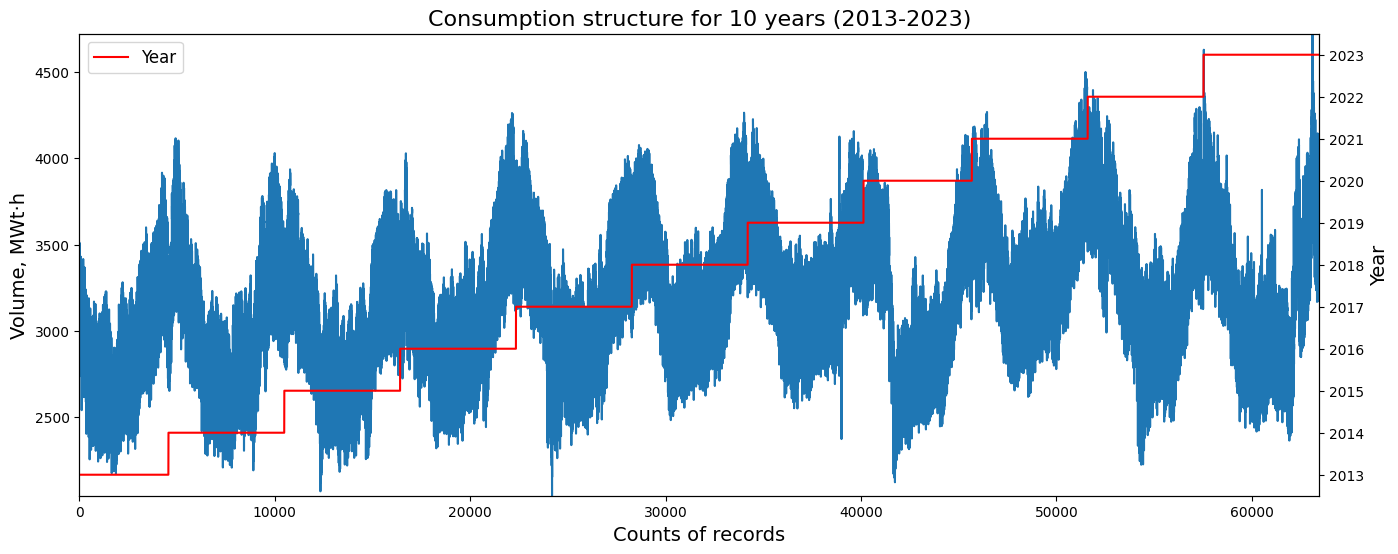

In [11]:
fig, df_volume = plt.subplots(figsize=(16,6))
df_year = df_volume.twinx()

df_volume.plot(df_general['Volume'], label='Volume')
df_year.plot(df_general['Year'], label='Year', color='red')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_general.shape[0])  #  поправить параметры при изменении периода исследования
df_volume.set_ylim(df_general['Volume'].min(), df_general['Volume'].max())  # диапазон 'volume' от min до max
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_year.set_ylabel('Year', fontsize = 14)
df_year.yaxis.set_major_locator(ticker.MultipleLocator(1.00))

plt.title('Сonsumption structure for 10 years (2013-2023)', fontsize = 16)
plt.legend()

*График структуры потребления электрической энергии по месяцам 2023 года*

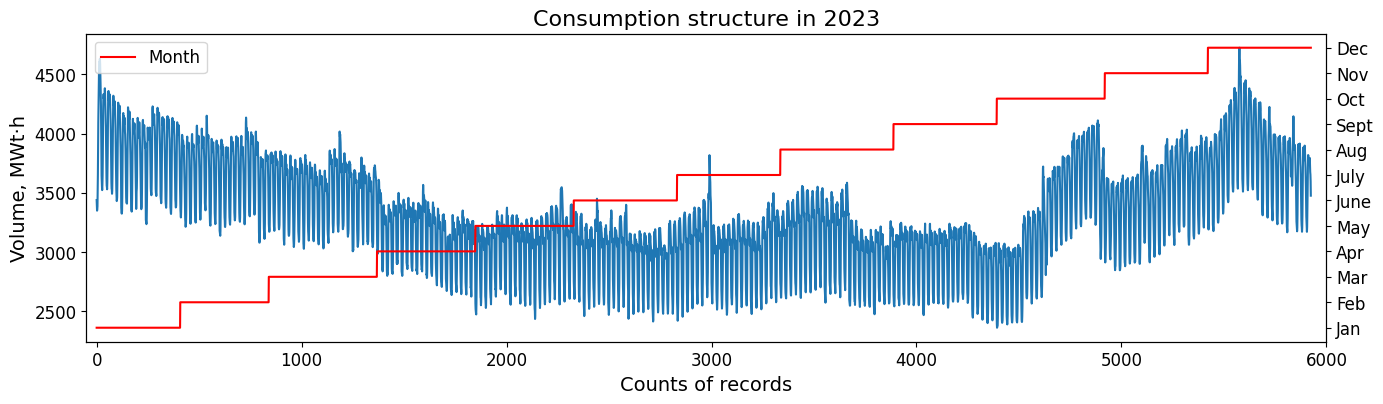

In [12]:
df_last_year = df_general[df_general['Year'] == datetime.now().year - 1]
df_last_year.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_month = df_volume.twinx()

df_volume.plot(df_last_year['Volume'], label='Volume')
df_month.plot(df_last_year['Month'], label='Month', color='r')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(-50, 6000)
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_month.yaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 13)]))
df_month.yaxis.set_major_formatter(ticker.FixedFormatter(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']))

plt.title('Сonsumption structure in 2023', fontsize = 16)
plt.legend()

*График зависимости усреднённой по дням температуры с усреднённым по дням потреблением ЭЭ для 2023 года*

Text(0.5, 1.0, 'Graph of average daily consumption and average daily temperature for 2023')

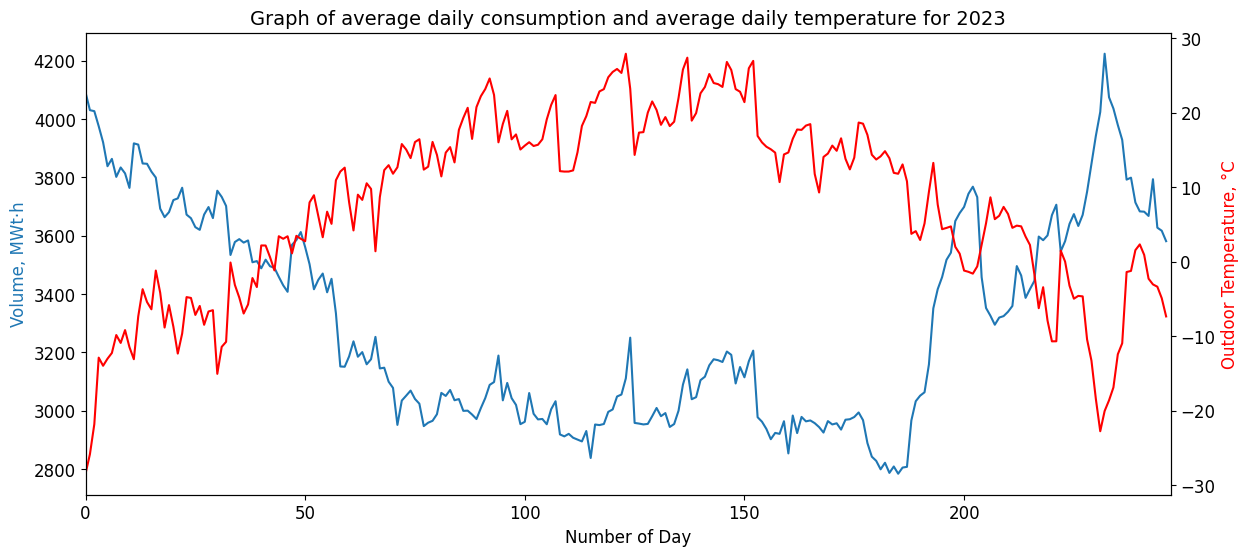

In [13]:
df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume', 'Temperature']].mean()
df_group_last_year.reset_index(drop=True, inplace=True) 

fig, df_volume = plt.subplots(figsize=(14,6))
df_temperature = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], color='#1f77b4', label='Volume')

df_temperature.plot(df_group_last_year['Temperature'], color = 'red', label = 'Temperature')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 12, color='#1f77b4')
df_volume.set_xlabel('Number of Day', fontsize = 12)
df_temperature.set_ylabel('Outdoor Temperature, °C', fontsize = 12, color='red')

plt.title('Graph of average daily consumption and average daily temperature for 2023', fontsize = 14)

**Вывод**: Наблюдается отчетливая корреляция между температурой наружного воздуха и объемом электропотребления

**Примечание**: 247 строк вместо 365, поскольку нет данных по выходным и празничным дням

*График структуры потребления электрической энергии по дням недели в декабре 2023 года*

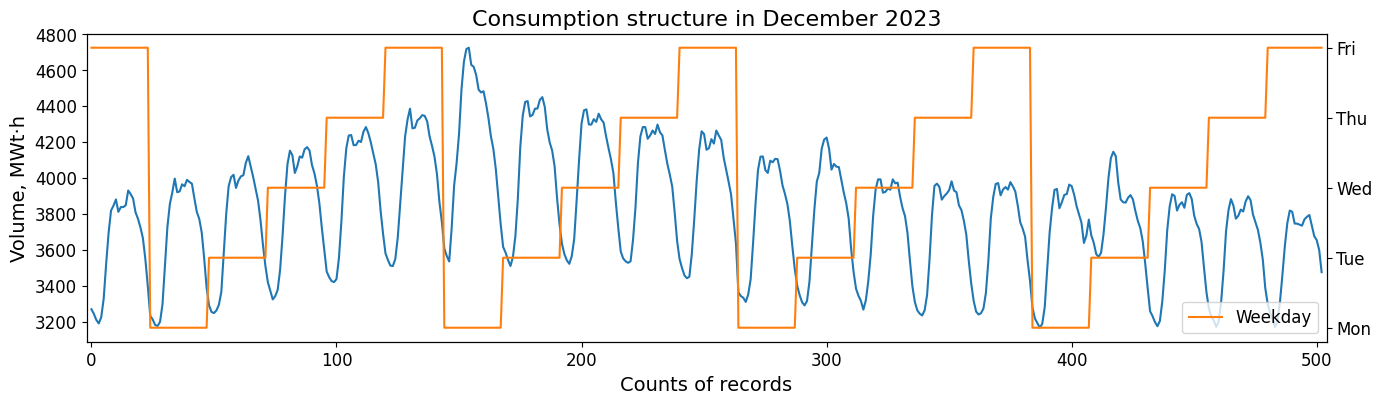

In [14]:
month = list(name for name in calendar.month_name)

df_month = df_test[df_test['Month'] == 12]  # указываем интересующий нас месяц
df_month.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_weekday = df_volume.twinx()

df_volume.plot(df_month['Volume'], label='Volume')
df_weekday.plot(df_month['Weekday'], label='Weekday', color='#ff7f0e')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(-2, 504)
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_weekday.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5, 6]))
df_weekday.yaxis.set_major_formatter(ticker.FixedFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

plt.title(f'Сonsumption structure in {month[df_month.Month[0]]} 2023', fontsize = 16)
plt.legend()

# Корреляция числовых и категориальных признаков

In [15]:
# корреляция исходных значений и целевого признака
color_map = sns.color_palette("vlag", as_cmap=True)

df_general.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)

,Year,Month,Day,Hour,Weekday,Volume,Temperature
Year,1.000000,-0.046280,-0.000478,-0.000167,0.009651,0.285216,-0.023209
Month,-0.046280,1.000000,-0.040304,-0.000120,-0.005199,-0.028820,0.109907
Day,-0.000478,-0.040304,1.000000,-0.000171,-0.004005,0.016103,-0.034428
Hour,-0.000167,-0.000120,-0.000171,1.000000,-0.000074,0.341930,0.061600
Weekday,0.009651,-0.005199,-0.004005,-0.000074,1.000000,0.007567,-0.000619
Volume,0.285216,-0.028820,0.016103,0.341930,0.007567,1.000000,-0.535554
Temperature,-0.023209,0.109907,-0.034428,0.061600,-0.000619,-0.535554,1.000000


**Вывод**: ощутимая корреляционная связь объема с годом, часом и температурой

# Регрессия Бустингом

## XGBoost

### Оценка ценности признаков

In [16]:
# исследуемый список датасетов с учетом ценности признаков
dataset = list([['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature'],
                ['Year', 'Month', 'Day', 'Hour', 'Temperature'],
                ['Year', 'Month', 'Hour', 'Temperature']])

predictions = list(['Predicted',
                    'Predicted_W',
                    'Predicted_WD'])

messages = list(['Full set:              ',
                 'Without Weekday:       ',
                 'Without Weekday & Day:'])

# классификация ценности признаков в контексте регрессора XGBoost
selector = xgb.XGBRegressor(random_state=10)
result = selector.fit(df_general[dataset[0]], df_general['Volume'])
features_table = pd.DataFrame(result.feature_importances_, index = dataset[0], columns = ['importance'])
features_table.sort_values(by='importance', ascending=False)


,importance
Hour,0.470435
Temperature,0.355421
Year,0.110073
Month,0.041726
Day,0.016319
Weekday,0.006024


### Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности
Обучение выполняется по методике, описанной в [статье](https://www.mdpi.com/2411-5134/8/5/114): валидация 1 к 3, количество деревьев `n_estimators` – 100, генеральная совокупность данных – за 3 года

In [18]:
%%time

# поиск лучших гиперпараметров XGBoost с помощью сетки гиперпараметров
df_boost_train = df_general[df_general['Year'] > 2020]  # формируем обучающий датафрейм
df_boost_test = df_test.copy()

XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 10)}, 
                          scoring='neg_mean_absolute_percentage_error', 
                          verbose = 0,
                          cv=3)

XGB_search.fit(df_boost_train[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature']], df_boost_train['Volume'])

XGB_best = XGB_search.best_estimator_

XGB_best.fit(df_boost_train[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature']], df_boost_train['Volume'])

# Предсказываем объемы потребления
df_boost_test['Predicted'] = XGB_best.predict(df_boost_test[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature']])

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

hyper_params = XGB_best.get_params()
print(f"max_depth: {hyper_params['max_depth']}, n_estimators: {hyper_params['n_estimators']}")

MAE: 78.75 [MW] 
MAPE: 2.42%
max_depth: 2, n_estimators: 100
CPU times: total: 24.5 s
Wall time: 10.5 s


### Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности (с фильтрацией исходных признаков и временного диапазона)

In [19]:
%%time

# инициализируем итоговый датафрейм по всем временным интервалам (3-10 лет)
df_general_result = pd.DataFrame({'period':[],  # рассматриваемый временной интервал
                                  'set': [],  # тип датасета
                                  'MAE [MW]':[],  # минимальная средняя абсолютная ошибка
                                  'MAPE':[],  # минимальная средняя относительная ошибка
                                  'max_depth':[],  # оптимальная глубина дерева
                                  'n_estimators':[]})  # оптимальное количество деревьев

index = 0  # индекс узла сетки итогового датафрейма

df_boost_test = df_test.copy()

for time in trange(2021, 2012, -1, desc=f"period progress"):  # виджет процесса расчёта оптимальных гиперпараметров

    df_boost_train = df_general[df_general['Year'] >= time]  # формируем обучающий датафрейм под рассматриваемый интервал

    for data in range(len(dataset)):  # выбор датасета

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 11)}, 
                          scoring='neg_mean_absolute_percentage_error',
                          verbose = 0,
                          cv=5)

        XGB_search.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)
        
        df_boost_test[predictions[data]] = XGB_best.predict(df_boost_test[dataset[data]])
        
        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time, messages[data], 
                                        MAE(df_boost_test[predictions[data]], df_boost_test['Volume']), 
                                        MAPE(df_boost_test[predictions[data]], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

#print()

period progress:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 28min 55s
Wall time: 9min 21s


In [30]:
i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
            'index': messages.index(df_general_result.set[i]),  # индекс оптимального датасета
            'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
            'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

print(best_HP)

df_general_result.style.highlight_min(color='yellowgreen', subset='MAPE')

{'period': 9, 'index': 0, 'max_depth': 10, 'n_estimators': 100}


,period,set,MAE [MW],MAPE,max_depth,n_estimators
0,3,Full set:,58.248846,0.017806,3,100
1,3,Without Weekday:,61.553644,0.018853,3,100
2,3,Without Weekday & Day:,83.071081,0.025529,2,100
3,4,Full set:,34.325169,0.010563,5,100
4,4,Without Weekday:,64.253071,0.019679,3,100
5,4,Without Weekday & Day:,86.115190,0.026394,2,100
6,5,Full set:,21.155154,0.006518,7,100
7,5,Without Weekday:,30.589940,0.009446,6,100
8,5,Without Weekday & Day:,38.559451,0.011849,9,100
9,6,Full set:,66.234838,0.020173,3,100


In [27]:
# ручная донастройка гиперпараметров
'''best_HP = {'period': 5,   # оптимальный временной период
            'index': 0,  # индекс оптимального датасета
            'max_depth': 7,   # отпимальная глубина дерева
            'n_estimators': 100}  # оптимальное колличество деревьев'''

*Предельные показатели метрики MAPE при различной глубине исследуемого интервала*

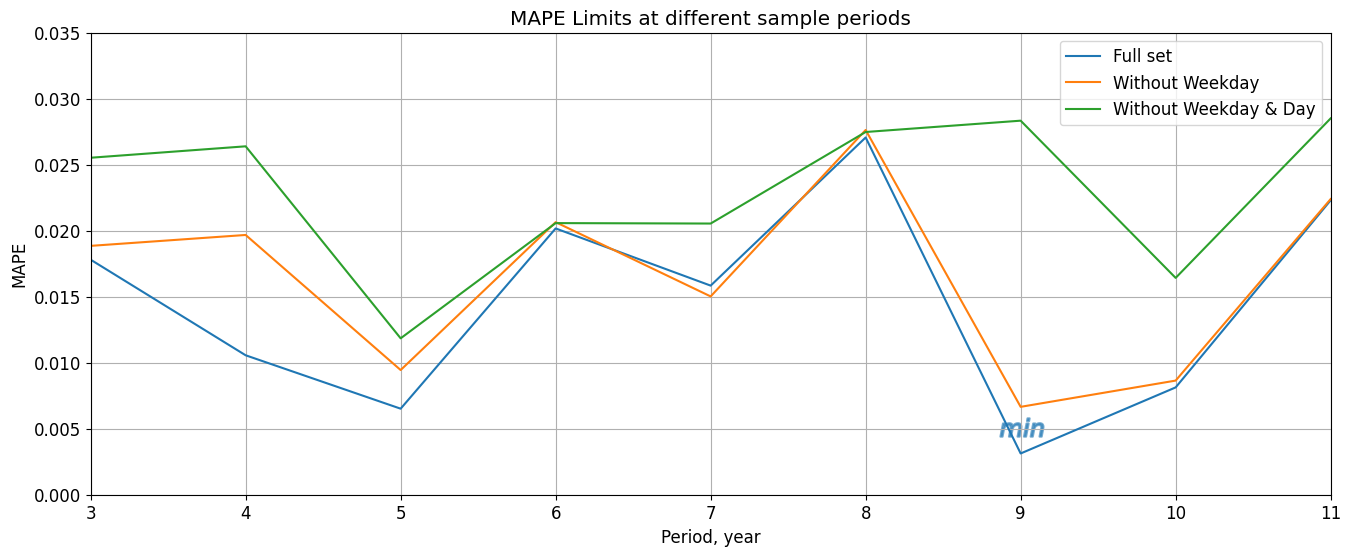

In [31]:
plot_gen = list()
for i in range(len(messages)):
    plot_gen.append(df_general_result[df_general_result['set'] == messages[i]])
    plot_gen[i]=plot_gen[i][['period', 'MAPE']]
    plot_gen[i].set_index('period', inplace= True)
    plot_gen[i] = plot_gen[i].rename(columns={'MAPE': messages[i].rstrip()[:-1]})

pd.concat([plot_gen[i] for i in range(3)], axis=1).plot(figsize=(16,6), 
                                                        title='MAPE Limits at different sample periods',
                                                        xlim=(3, 11), ylim=(0, 0.035),
                                                        xlabel='Period, year',
                                                        ylabel='MAPE',
                                                        legend=True,
                                                        grid=True)

plt.scatter(df_general_result.period[df_general_result.MAPE.idxmin()], 
            df_general_result.MAPE.min()+0.002,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

**Выводы**: 
1. Фильтрация малозначимых исходных данных в *большинстве* случаев **снижает** точность прогнозной модели. 
2. Ограничение объема тестовой выборки приводит к **снижению** погрешности на 0.18–1.28% (!). Лучший результат был получен для тестовой выборки объемом в **5-6 лет**.
3. Полученный результат близок к тому, что описан в [статье](https://www.mdpi.com/2411-5134/8/5/114)

*Оценка прогнозирования за 2023 год при оптимальных гиперпараметрах с разбивкой по месяцам*

In [32]:
%%time

df_boost_test = df_test.copy()  # формируем тестовый датафрейм
df_boost_train = df_general[df_general['Year'] > datetime.now().year - best_HP['period'] - 1]  # формируем обучающий датафрейм

# обучаем модель
model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                         n_estimators = best_HP['n_estimators'],
                         max_depth = best_HP['max_depth'])

model.fit(df_boost_train[dataset[best_HP['index']]], df_boost_train['Volume'])
df_boost_test[predictions[best_HP['index']]] = model.predict(df_boost_test[dataset[best_HP['index']]])

CPU times: total: 2.31 s
Wall time: 1.94 s


In [33]:
month = list(name for name in calendar.month_name)

df_month_result = pd.DataFrame({'Month':[],
                                'MAE [MW]':[],
                                'MAPE':[]})

for i in range(12):
    df_month = df_boost_test[df_boost_test['Month'] == i + 1]
    if df_month.shape[0]:
        df_month_result.loc[i] = (month[i + 1],
                                  f"{MAE(df_month[predictions[best_HP['index']]], df_month['Volume']):.2f}", 
                                  f"{MAPE(df_month[predictions[best_HP['index']]], df_month['Volume']):.3%}")


#df_month_result.set_index("Month")
df_month_result

,Month,MAE [MW],MAPE
0,January,8.31,0.215%
1,February,9.62,0.261%
2,March,10.75,0.306%
3,April,10.76,0.345%
4,May,8.48,0.283%
5,June,12.15,0.409%
6,July,9.00,0.301%
7,August,8.77,0.290%
8,September,10.68,0.366%
9,October,12.84,0.398%


### Валидация на свежих данных (январь 2024)

In [34]:
# Предсказываем объемы потребления на валидационной выборке
df_validate[predictions[best_HP['index']]] = model.predict(df_validate[dataset[best_HP['index']]])

# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate[predictions[best_HP['index']]], df_validate['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate[predictions[best_HP['index']]], df_validate['Volume']):.2%}")

df_validate

MAE: 69.74 [MW] 
MAPE: 1.79%


,Year,Month,Day,Hour,Weekday,Volume,Temperature,Predicted
0,2024,1,9,1,1,3533.232,-17.0,3583.958496
1,2024,1,9,2,1,3494.442,-19.5,3551.427734
2,2024,1,9,3,1,3442.868,-21.0,3521.706543
3,2024,1,9,4,1,3452.745,-21.3,3521.354736
4,2024,1,9,5,1,3467.223,-20.7,3543.456543
...,...,...,...,...,...,...,...,...
400,2024,1,31,17,2,4015.744,-3.5,4095.204834
401,2024,1,31,18,2,4009.686,-4.0,4082.052490
402,2024,1,31,19,2,3933.118,-4.6,4036.341553
403,2024,1,31,20,2,3914.372,-5.2,3972.201416


*Сравнение прогнозных значений с фактическими*

Text(0.5, 1.0, 'The segment of the model testing process (January 2024)')

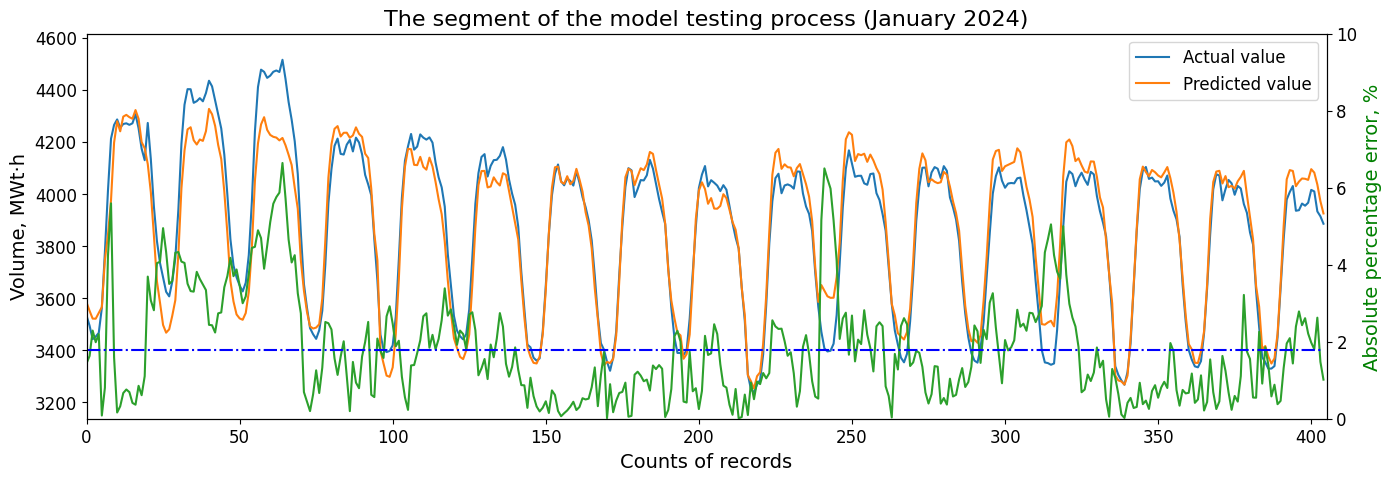

In [36]:
# добавление новых столбцов
df_validate_graph = df_validate.copy()

df_validate_graph.insert(df_validate_graph.shape[1], 'MAPE', 
                         MAPE(df_validate_graph[predictions[best_HP['index']]], df_validate_graph['Volume'])*100)

df_validate_graph['Error'] = abs((df_validate_graph['Volume'] - df_validate_graph[predictions[best_HP['index']]])*100
                             /df_validate_graph['Volume'])

df_validate_graph.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,5))
df_error = df_volume.twinx()

df_volume.plot(df_validate_graph['Volume'], label='Actual value')
df_volume.plot(df_validate_graph[predictions[best_HP['index']]], label='Predicted value')
df_error.plot(df_validate_graph['Error'], label='Error, %', color='#2ca02c')
df_error.plot(df_validate_graph['MAPE'], '-.b')

plt.rcParams['font.size'] = '12'

df_volume.legend(loc='upper right')
df_volume.set_xlim(0, df_validate_graph.shape[0])
df_volume.set_ylim(df_validate_graph.Volume.min() - 100, df_validate_graph.Volume.max() + 100)
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)

df_error.set_ylim(0, 10)
df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

plt.title(f'The segment of the model testing process ({month[df_validate_graph.Month[0]]} {datetime.now().year})', 
          fontsize = 16)